# Cargamos el Dataset de Kaggle que contiene los datos para el análisis

* Se llama Sentiment140  
* Contiene 1.6 million tweets
* https://www.kaggle.com/datasets/kazanova/sentiment140

## Importamos las bibliotecas necesarias.

In [ ]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

!pip install kaggle

# Upload your kaggle.json file
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kazanova/sentiment140

!unzip sentiment140.zip

data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Contiene:

1. target: la polaridad del tweet (0 = negativo, 4 = positivo)
2. ids: El id del tweet
3. date: la fecha del tuit (Sat May 16 23:58:44 UTC 2009)
4. flag: La consulta (lyx). Si no hay consulta, este valor es NO_QUERY.
5. user: el usuario que tuiteó
6. text: el texto del tweet (Lyx is cool)

Datos necesarios para un Análisis de sentimientos

In [ ]:
new_df = data[['target', 'text']]
new_df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


# Preprocesamiento de los datos

Eliminación de los identificadores de usuario

In [ ]:
def remove_user_handlers(text):
    return re.sub(r'@\w+\s?', '', text)

new_df['text'] = new_df['text'].apply(remove_user_handlers)

<ipython-input-4-eab90edb4ca8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['text'] = new_df['text'].apply(remove_user_handlers)


Eliminación de las URL

In [ ]:
!pip install nltk

In [ ]:
from nltk.tokenize import word_tokenize

Tokenización es una tarea fundamental cuando se trabaja en tareas de PNL. Consiste en descomponer el texto en unidades más pequeñas, conocidas como tokens, que pueden ser palabras, subpalabras o caracteres

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Se importa el módulo stopwords, que proporciona una lista predefinida de palabras vacías ("stop words") en diferentes idiomas.

El módulo re proporciona funciones y métodos para realizar operaciones con expresiones regulares, como coincidencias, búsquedas y reemplazos en cadenas de texto.

In [ ]:
from nltk.corpus import stopwords
import re


stop_words = set(stopwords.words('english'))

def preprocess_text(text):

    # Eliminación de URL
    text = re.sub(r"https?://\S+|www\.\S+"," ",text)

    # Eliminación de signos de puntuación y caracteres especiales
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower()

    tokens = word_tokenize(text)

    # Tratamiento de las palabras vacías
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 3:
            filtered_tokens.append(token)

    return filtered_tokens

new_df['cleaned_tweet'] = new_df['text'].apply(preprocess_text)

<ipython-input-13-0c0228e572ef>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cleaned_tweet'] = new_df['text'].apply(preprocess_text)


In [ ]:
new_df

,target,text,cleaned_tweet
0,0,"http://twitpic.com/2y1zl - Awww, that's a bumm...","[awww, thats, bummer, shoulda, david, carr, th..."
1,0,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might..."
2,0,I dived many times for the ball. Managed to sa...,"[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
4,0,"no, it's not behaving at all. i'm mad. why am ...","[behaving, cant]"
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]"
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,"[thewdbcom, cool, hear, walt, interviews]"
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, details]"
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, 38th, birthday, alll, time, tupac, ama..."


# EDA (Análisis Exploratorio de Datos)

Los tweets han sido anotados:
* 0 = negativo
* 4 = positivo

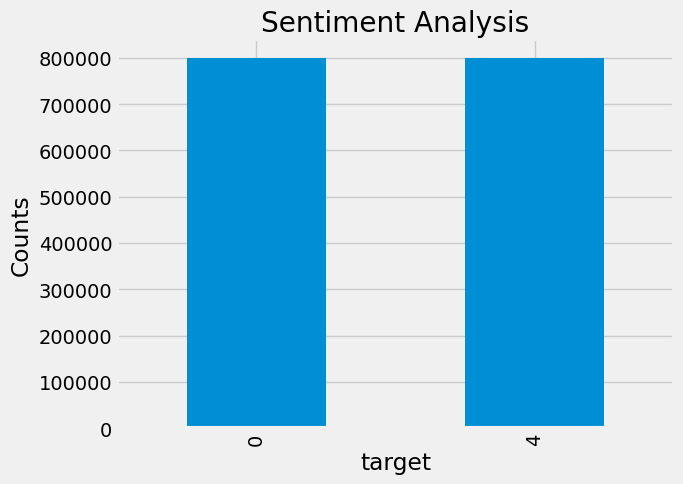

In [ ]:
new_df['target'].value_counts()

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
new_df['target'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
import seaborn as sns

<ipython-input-17-b9184b0323c1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=top_20_words_df, palette='viridis')


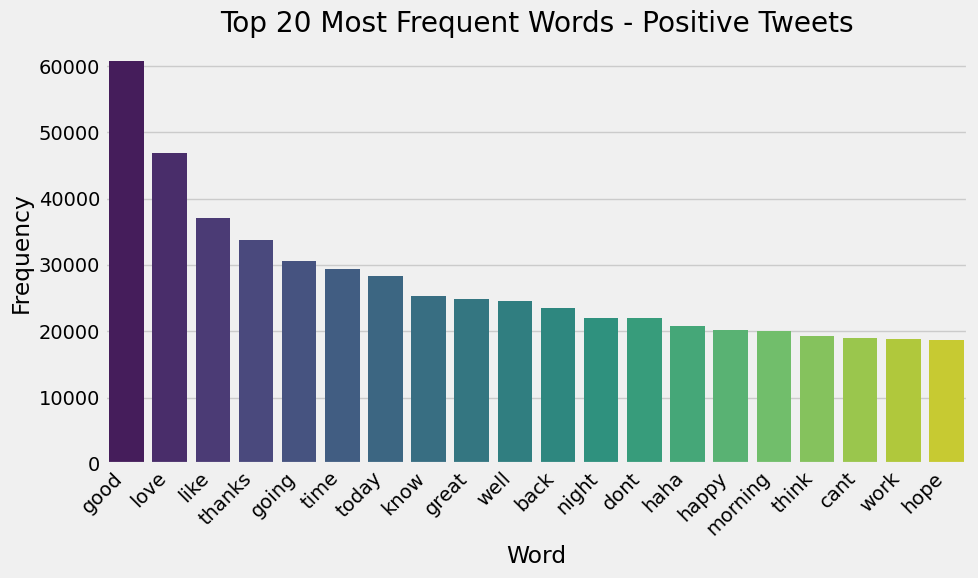

In [ ]:
# Filtrar tuits positivos
positive_twitter_df = new_df[new_df['target'] == 4]

# Reunir todas las palabras
all_positive_words = [word for sublist in positive_twitter_df['cleaned_tweet'] for word in sublist]

# Calcular la frecuencia de cada palabra
word_freq_positive = nltk.FreqDist(all_positive_words)

# Creación de un DF a partir de datos
most_freq_pos_df = pd.DataFrame(list(word_freq_positive.items()), columns=['Word', 'Frequency'])

most_freq_pos_df = most_freq_pos_df.sort_values(by='Frequency', ascending=False)

top_20_words_df = most_freq_pos_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top_20_words_df, palette='viridis')
plt.title('Top 20 Most Frequent Words - Positive Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-18-9c127530ffff>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=top_20_words_df, palette='viridis')


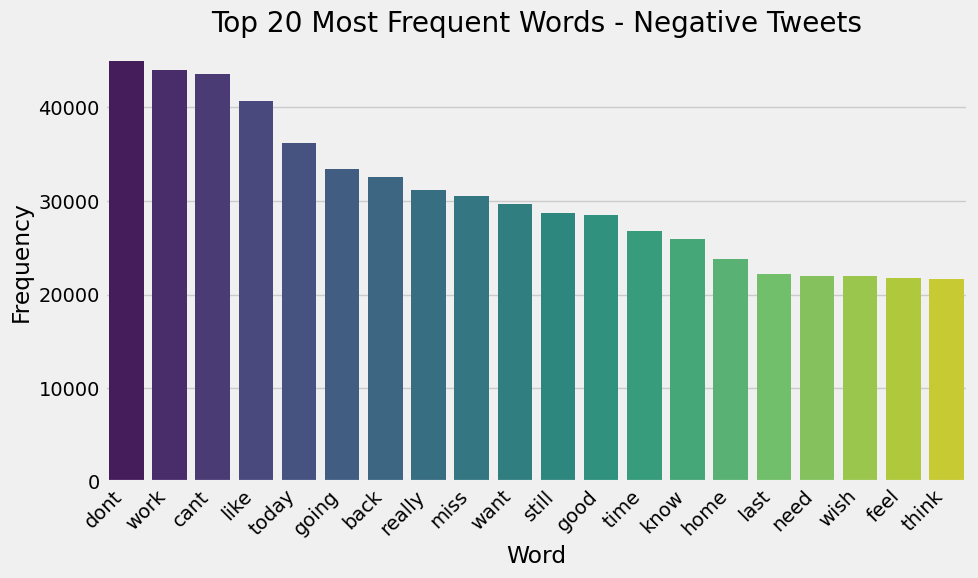

In [ ]:
# Filtrar tuits negativos
positive_twitter_df = new_df[new_df['target'] == 0]

# Reunir todas las palabras
all_positive_words = [word for sublist in positive_twitter_df['cleaned_tweet'] for word in sublist]

# Calcular la frecuencia de cada palabra
word_freq_positive = nltk.FreqDist(all_positive_words)

# Creación de un DF a partir de datos
most_freq_pos_df = pd.DataFrame(list(word_freq_positive.items()), columns=['Word', 'Frequency'])

most_freq_pos_df = most_freq_pos_df.sort_values(by='Frequency', ascending=False)

top_20_words_df = most_freq_pos_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Word', y='Frequency', data=top_20_words_df, palette='viridis')
plt.title('Top 20 Most Frequent Words - Negative Tweets')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Transformación de datos

 **Utilizando el vectorizador de recuento**


El CountVectorizer es una técnica que convierte texto en representaciones numéricas basadas en la frecuencia de las palabras en un corpus.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

new_df['cleaned_tweet_text'] = new_df['cleaned_tweet'].apply(lambda x: ' '.join(x))

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# crea una "matriz dispersa" para guardar la "Matriz de frecuencia de palabras"
bow_sparse = bow_vectorizer.fit_transform(new_df['cleaned_tweet_text'])

# Convierte la "matriz dispersa" en un DataFrame
df_bow = pd.DataFrame.sparse.from_spmatrix(bow_sparse)

<ipython-input-19-cc774ebf05ce>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cleaned_tweet_text'] = new_df['cleaned_tweet'].apply(lambda x: ' '.join(x))


**Separación de los datos en Entrenamiento y Prueba**

In [ ]:
from sklearn.model_selection import train_test_split

X = df_bow
y = new_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=911)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
652525,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1463678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
600528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1460796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
y_train

,target
652525,0
1129899,4
218467,0
1463678,4
600528,0
...,...
131167,0
1460796,4
165832,0
73394,0


# Métodos de clasificación

## Random Forest

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=911)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=911)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [ ]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.49      0.60    160260
           4       0.63      0.86      0.72    159740

    accuracy                           0.67    320000
   macro avg       0.70      0.67      0.66    320000
weighted avg       0.70      0.67      0.66    320000



## Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression

# Inicializar el modelo de regresión logística
logreg_model = LogisticRegression(max_iter=1000)

# Entrenar el modelo
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_pred_logreg = logreg_model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71    160260
           4       0.70      0.79      0.74    159740

    accuracy                           0.72    320000
   macro avg       0.73      0.72      0.72    320000
weighted avg       0.73      0.72      0.72    320000



## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Inicializar el modelo Naive Bayes
nb_model = MultinomialNB()

# Entrenar el modelo
nb_model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_pred_nb = nb_model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71    160260
           4       0.71      0.75      0.73    159740

    accuracy                           0.72    320000
   macro avg       0.72      0.72      0.72    320000
weighted avg       0.72      0.72      0.72    320000



## Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Inicializar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=911)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=911)

In [ ]:
# Hacer predicciones en el conjunto de prueba
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.77      0.46      0.57    160260
           4       0.61      0.87      0.72    159740

    accuracy                           0.66    320000
   macro avg       0.69      0.66      0.65    320000
weighted avg       0.69      0.66      0.65    320000

